<a href="https://colab.research.google.com/github/MatthewYancey/16-9GAN/blob/master/model_gans_right_side.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16:9 Generative Model
This notebook takes images that are in a 4:3 aspect ratio and converts them to 16:9 aspect ratio.

## Imports and Parameters

In [2]:
import shutil
import glob
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# network parameters
BATCH_SIZE = 10
DATASET_SIZE = 2100
N_BATCHES = (DATASET_SIZE // BATCH_SIZE) * 2 # divide by two because we have two data loaders and the batch size is split between them
N_GPU = 1
N_WORKERS = 1
N_EPOCHS = 100
LEARNING_RATE = 0.01

# image
IMG_WIDTH = 320
IMG_HEIGHT = 180
SINGLE_SIDE = 40

# directories
ZIP_DIR = '/content/gdrive/My Drive/16:9GAN/data_out/frames_16_9.zip'
IMG_DIR = '/content/frames/'
LOG_DIR = '/content/gdrive/My Drive/16:9GAN/data_out/logs/model_002/'

# testing index
testing_index = [3]

# checkpoint type
CHECKPOINT_TYPE = 'none' # none or prev_checkpoint

In [4]:
shutil.unpack_archive(ZIP_DIR, IMG_DIR, 'zip')

## Create the Data Loaders and Load the Data

In [5]:
img_list = glob.glob(IMG_DIR + '*')
img_list.sort()
print(f'Number of images: {len(img_list)}')
img_list = img_list[:DATASET_SIZE]
print(f'Number of images for training: {len(img_list)}')

Number of images: 2143
Number of images for training: 2100


In [6]:
# a custom dataset class for reading in our images from the list
class ReadFromList(Dataset):

    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image = Image.open(self.img_list[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image

In [7]:
# helper function for apply the mask or cutting the frame to 4:3
def apply_mask(batch, single_side=True):
    if single_side:
        batch[:, :, :, (IMG_WIDTH - SINGLE_SIDE):] = -1
        return batch

In [8]:
# makes the dataset and data loader
dataset = ReadFromList(img_list, transform=transforms.Compose([
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE//2, shuffle=True, num_workers=N_WORKERS)
print(f'Size of dataset: {len(dataloader.dataset)}')

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and N_GPU > 0) else "cpu")
print(f'Device: {device}')

Size of dataset: 2100
Device: cpu


### Plot random images of 4:3 and 16:9

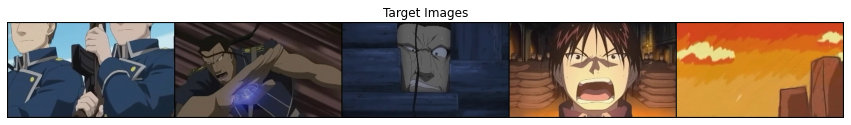

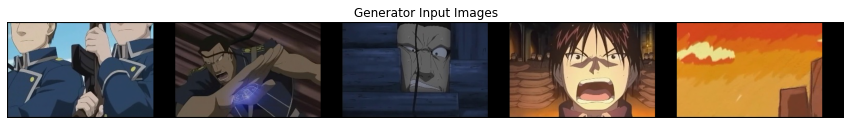

In [9]:
# Plot some training images
batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

batch = apply_mask(batch)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Generator Input Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

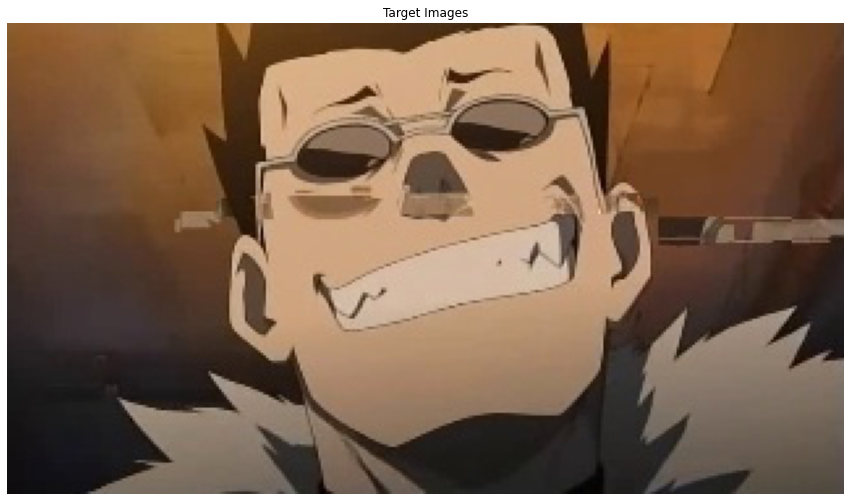

In [10]:
# makes a dataloader for keeping the spot check image that will be on tensorboard
dataset_spotcheck = torch.utils.data.Subset(dataset, testing_index)
dataloader_spotcheck = torch.utils.data.DataLoader(dataset_spotcheck, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
batch = next(iter(dataloader_spotcheck))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=4).cpu(),(1,2,0)))

## Networks

### Generartor

In [11]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.dilconv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=2, padding=2)
        self.dilconv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=4, padding=4)
        self.dilconv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=8, padding=8)
        self.dilconv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=16, padding=16)

        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv10 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

        self.batch_norm3 = nn.BatchNorm2d(3)
        self.batch_norm32 = nn.BatchNorm2d(32)
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.batch_norm256 = nn.BatchNorm2d(256)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        # encoding
        x = self.conv1(img)
        x = self.batch_norm64(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch_norm128(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        # dilation
        x = self.dilconv1(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv2(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv3(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv4(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        # more encoding
        x = self.conv7(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv8(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        # decoding
        x = self.deconv1(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.conv9(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.deconv2(x)
        x = self.batch_norm64(x)
        x = self.relu(x)

        x = self.conv10(x)
        x = self.batch_norm32(x)
        x = self.relu(x)

        # output
        x = self.conv11(x)
        x = self.tanh(x)

        # combines with the original image
        local_gen_output = x[:, :, :, (IMG_WIDTH - SINGLE_SIDE):]
        img = self.tanh(img)
        img = img[:, :, :, :(IMG_WIDTH - SINGLE_SIDE)]
        global_gen_output = torch.cat((img, local_gen_output), 3)

        return (local_gen_output, global_gen_output)

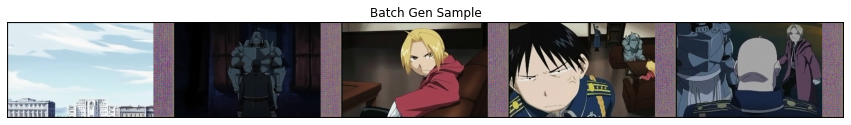

In [13]:
# check the generator output
gen = Generator(N_GPU).to(device)
gen.apply(weights_init)

batch = next(iter(dataloader))
# batch = batch.cuda()
batch = apply_mask(batch)
local_gen_output, global_gen_output = gen(batch)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Batch Gen Sample')
plt.imshow(np.transpose(vutils.make_grid(global_gen_output.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

### Discriminators

#### Global Discriminator

In [14]:
class GlobalDiscriminator(nn.Module):
    def __init__(self, ngpu):
        super(GlobalDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)

        self.batch64 = nn.BatchNorm2d(64)
        self.batch128 = nn.BatchNorm2d(128)
        self.batch256 = nn.BatchNorm2d(256)
        self.batch512 = nn.BatchNorm2d(512)

        self.linear = nn.Linear(512*3*5, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch64(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch128(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch256(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = x.view(-1, 512*3*5)
        x = self.linear(x)
        x = self.sigmoid(x)

        return x

### Initialize the Networks

In [15]:
gen = Generator(N_GPU).to(device)
global_disc = GlobalDiscriminator(N_GPU).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (N_GPU > 1):
#     gen = nn.DataParallel(netG, list(range(N_GPU)))

gen.apply(weights_init)
global_disc.apply(weights_init)

GlobalDiscriminator(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv5): Conv2d(512, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv6): Conv2d(512, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (batch64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=7680, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

### Testing Generator output

## Training

### Loads Checkpoints

In [16]:
if CHECKPOINT_TYPE == 'prev_checkpoint':
    # loads the model weights
    checkpoint = torch.load(LOG_DIR + 'checkpoint.pt')
    gen.load_state_dict(checkpoint['gen_state'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print('Checkpoint Loaded')
    
    # loads the epoch counter
    with open(LOG_DIR + 'itercount.txt', 'r') as f:
        batch_counter = int(f.read())
    # moves it up one becuase it's currenlty at the last epoch we did
    batch_counter += 1

elif CHECKPOINT_TYPE == 'none':
    # remove all previous logs
    try:
        shutil.rmtree(LOG_DIR)
        print('Folders removed')
    except FileNotFoundError:
        print('No log folder found')

    batch_counter = 1

else:
    print('Failed to specify a type')

Folders removed


### Function for saving checkpoints on the model

In [17]:
def checkpoint(epoch, i, batch_counter, loss_value):
    print(f'Epoch: {epoch}/{N_EPOCHS}, Batch in Epoch: {i}/{N_BATCHES}, Total Images {batch_counter * BATCH_SIZE}, Loss: {loss_value:.2f}')

    # saves everything once every epoch
    if i == 0:
        # saves loss to the tensorboard log    
        writer.add_scalar('Loss/Training', loss_value.item(), batch_counter)

        # saves a checkpoint
        checkpoint = {'gen_state': gen.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(checkpoint, LOG_DIR + 'checkpoint.pt')

        # Saves an image so we can view the progression
        test_inputs = next(iter(dataloader_spotcheck))
        test_inputs = test_inputs.cuda()
        with torch.no_grad():
            output = gen(test_inputs)[1]
        grid = torchvision.utils.make_grid(output, normalize=True)
        writer.add_image('image_epoch_%d' % batch_counter, grid)

        # saves the epoch counter
        with open(LOG_DIR + '/itercount.txt', 'w') as f:
            f.write(str(batch_counter))
        
        print('Saved checkpoint')

### Loss Function and Optimizer

In [18]:
loss = nn.BCELoss()
optimizer_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))
optimizer_disc = optim.Adam(global_disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))

### Training Loop

In [ ]:
writer = SummaryWriter(LOG_DIR)


for epoch in range(N_EPOCHS):
    # gets data for the generator
    for i, batch in enumerate(dataloader, 0):

        # passing target images to the Discriminator
        global_disc.zero_grad()
        output_disc = global_disc(batch.cuda())
        error_target = loss(output_disc, torch.ones(output_disc.shape).cuda())

        # apply mask to the images
        batch = apply_mask(batch)

        # passes fake images to the Discriminator
        global_output, local_output = gen(batch.cuda())
        output_disc = global_disc(global_output)
        error_fake = loss(output_disc, torch.zeros(output_disc.shape))

        # combines the errors and calculates the gradiants
        error_total = error_target + error_fake
        error_total.backward()
        optimizer_disc.step()

        # updates the generator
        global_disc.zero_grad()
        gen.zero_grad()
        error_gen = loss(output_disc, torch.ones(output_disc.shape))
        error_gen.backward()
        optimizer_gen.step()        

        break
    break




In [ ]:
writer = SummaryWriter(LOG_DIR)

# trianing loop
for epoch in range(N_EPOCHS):

    running_loss = 0
    target_iter = iter(dataloader_target)
    for i, batch_gen in enumerate(dataloader_gen):

        batch_target = next(iter(dataloader_target))
        
        # moves the images to the GPU
        batch_gen = batch_gen.cuda()
        batch_target = batch_target.cuda()

        # feeds the generator
        gen_local_output, gen_global_output = gen(batch_gen.cuda())

        # passes in the generated images
        # local_disc_output = local_disc(gen_local_output)
        global_disc_output_gen = global_disc(gen_global_output)
        # concat_output_gen = concat_layer(local_disc_output, global_disc_output)

        # passes in the authentic images
        # local_disc_output = local_disc(batch_target[:, :, :, (IMG_WIDTH - SINGLE_SIDE):])
        global_disc_output_target = global_disc(batch_target)
        # concat_output_target = concat_layer(local_disc_output, global_disc_output)

        # concatenates the outputs
        # concat_output = torch.cat((concat_output_gen, concat_output_target), 0)
        concat_output = torch.cat((global_disc_output_gen, global_disc_output_target), 0)

        # calcualtes the loss and optimizes
        targets = torch.tensor([[0.0]]*(BATCH_SIZE//2) + [[1.0]]*(BATCH_SIZE//2)).cuda()
        loss_value = loss(concat_output, targets)
        loss_value.backward()
        optimizer.step()

        # checkpoints and print statistics every 10 batches
        if i % 10 == 0:
            checkpoint(epoch, i, batch_counter, loss_value)
        
        batch_counter += 1
        
writer.close()